In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Utils import *
from Evaluation import *
from Read_Platelayouts import load_layout
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd

# Hefekulturen

To generate a broad understanding of the p-value and its meaning in statistics, please read: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5665734/

## 1. Set Variables

### 1.1 Link Files To Evaluate
Please edit the path to the reference plate (`path_to_reference_plate`) and experiment plate (`path_to_experiment_plate`) as well as the folder to save the results to (`save_results_folder`)

**Attention** Please make sure that the images are cropped, in such way that only the yeast colonies are visible.

In [3]:
path_to_reference_plate = r"/home/hansel/Data/Hefekulturen/Data_May_2023/Spa2/C_Gen_D3.JPG" # Spa2/C_Gen_D3.JPG" #r"./Data\36_MPA_ref_d3.JPG" # 
path_to_experiment_plate = r"/home/hansel/Data/Hefekulturen/Data_May_2023/Spa2/C_Cu50_D3.JPG" #r"./Data\36_MPA_Cu0_d3.JPG"  #

save_results_folder = r"./Results_May2024/Spa2/"

### 1.2. Optional Variables - Troubleshoot
If you are encountering issues during section 2.2. you can try to change the following variable. 

Please only set `USE_HARD_GRID` to `True` if the grid (Section *2.2. Compute Colony Sizes*) is not working properly.

WARNING:: This can lead to small inaccuracies at colony borders.

In [4]:
USE_HARD_GRID = False #True

### 1.3. Optional Variables
Please only change if you know what you are doing.

`MIN_COLONY_SIZE` is used to exclude colonies that did not grow. The value is defined by the smallest 3% of all colonies computed over a set of experiment and reference plates. The value was set based on experience. Please only change if you know what you are doing. 



In [5]:
MIN_COLONY_SIZE = 85.0 # this is approximated by the smallest 3% in all plates 

`P_VALUE_NULLHYPOTHESIS` is the considered p-value of the statistical tests used for finding significant differences between row A and B. Please only change if you know what you are doing. 

In [6]:
P_VALUE_NULLHYPOTHESIS = 0.01

**Exp1: Absolut Growth**

*Evaluate growth of row A and B compared to other colonies on plate.*

If `PERCENTILE` is set to -1 (use as default), use outlier detection based on IQR (Interquantilerange) to find colonies that have grown significantly more than other colonies on plate.

However, `PERCENTILE` can be adapted to detect values above certain percentile. To define the percentile set the variable to a value between 1 - 100

In [7]:
PERCENTILE = -1 # only change when you know what you are doing.

### 1.4. Preparation

TODO: Layout changes explain

In [8]:
if("A_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 32 
    layout_names = load_layout('Plate_Layouts/MPA.csv')
    # TODO load names
elif("B_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 32 
    layout_names = load_layout('Plate_Layouts/MPB.csv')
elif("C_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 28 
    layout_names = load_layout('Plate_Layouts/MPCD.csv')


In [9]:
os.makedirs(save_results_folder, exist_ok=True)

## 2. Open and Preprocess Images

### 2.1. Open Images as Binary

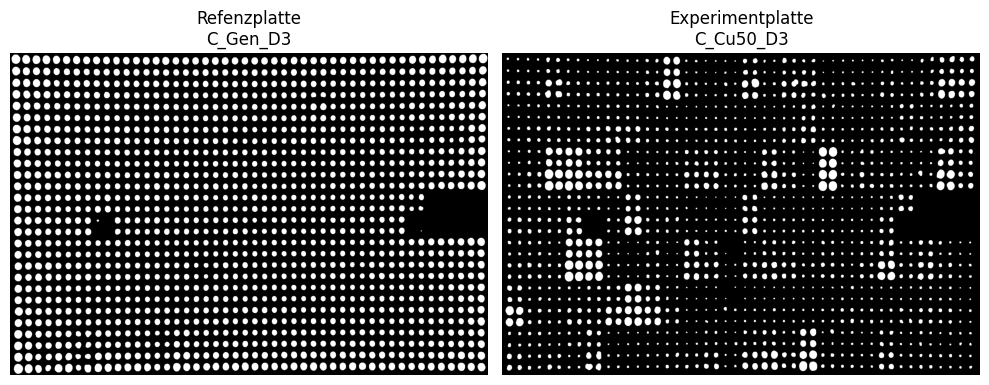

In [10]:
reference_plate = open_image(path_to_reference_plate)
experiment_plate = open_image(path_to_experiment_plate)

fig, axs = plt.subplots(1,2, figsize = (10,10*2))
axs[0].imshow(reference_plate, cmap="gray")
axs[1].imshow(experiment_plate, cmap="gray")
axs[0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

### 2.2. Compute Colony Sizes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


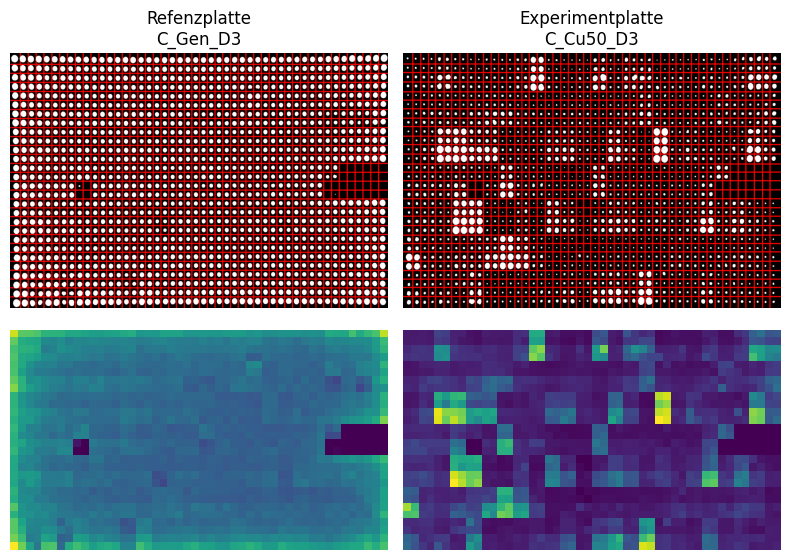

In [11]:
rgb_grid_reference, sizes_reference, x_start, x_end, y_start, y_end = compute_grid(reference_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)
rgb_grid_experiment, sizes_experiment, x_start, x_end, y_start, y_end = compute_grid(experiment_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)

if((not np.any(rgb_grid_reference == None)) and (not np.any(rgb_grid_experiment == None))):
    fig, axs = plt.subplots(2,2, figsize = (4*2,4*1.5))
    axs[0,0].imshow(rgb_grid_reference)
    axs[0,1].imshow(rgb_grid_experiment)
    axs[0,0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
    axs[0,1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
    axs[0,0].set_axis_off()
    axs[0,1].set_axis_off()

    axs[1,0].imshow(sizes_reference) #, cmap= "plasma")
    axs[1,1].imshow(sizes_experiment) #, cmap= "plasma")
    axs[1,0].set_axis_off()
    axs[1,1].set_axis_off()
    plt.tight_layout()
    plt.autoscale(False)
    plt.show()



## 3. Evaluate
- Normalize experimental plate in relation to reference plate
    - Row/col Effect is dealt with by normalizing based on reference plate
    - Same for Edge Effect
    - Jack-Knife: removes quadruples where not all colonies have grown (markes as invalid)
- Find invalid quadruples (Exclude inaccuracies on reference plate and missing values)
- Exp1: Find quadruple where either all colonies of the row A quadruple or all colonies of the row B quadruple are outliers compared to other colonies
- Exp2: Find siginificant differences between row A and row B
- Saves .pdf into results folder with images

Results are sorted in such way, that first quadruples are shown that are significant in Exp1 and Exp2, while being sorted by their effect size of Exp2. 
Next, results are shown, which are only significant in Exp2 - again sorted by their effect size. 
Next, results are shown which are only significant in Exp 1 - sorted by the mean normalized size of the row with bigger growth
Next, quadruples which do not show significance in either experiments are listed
Finally, invalid quadruples are listed.

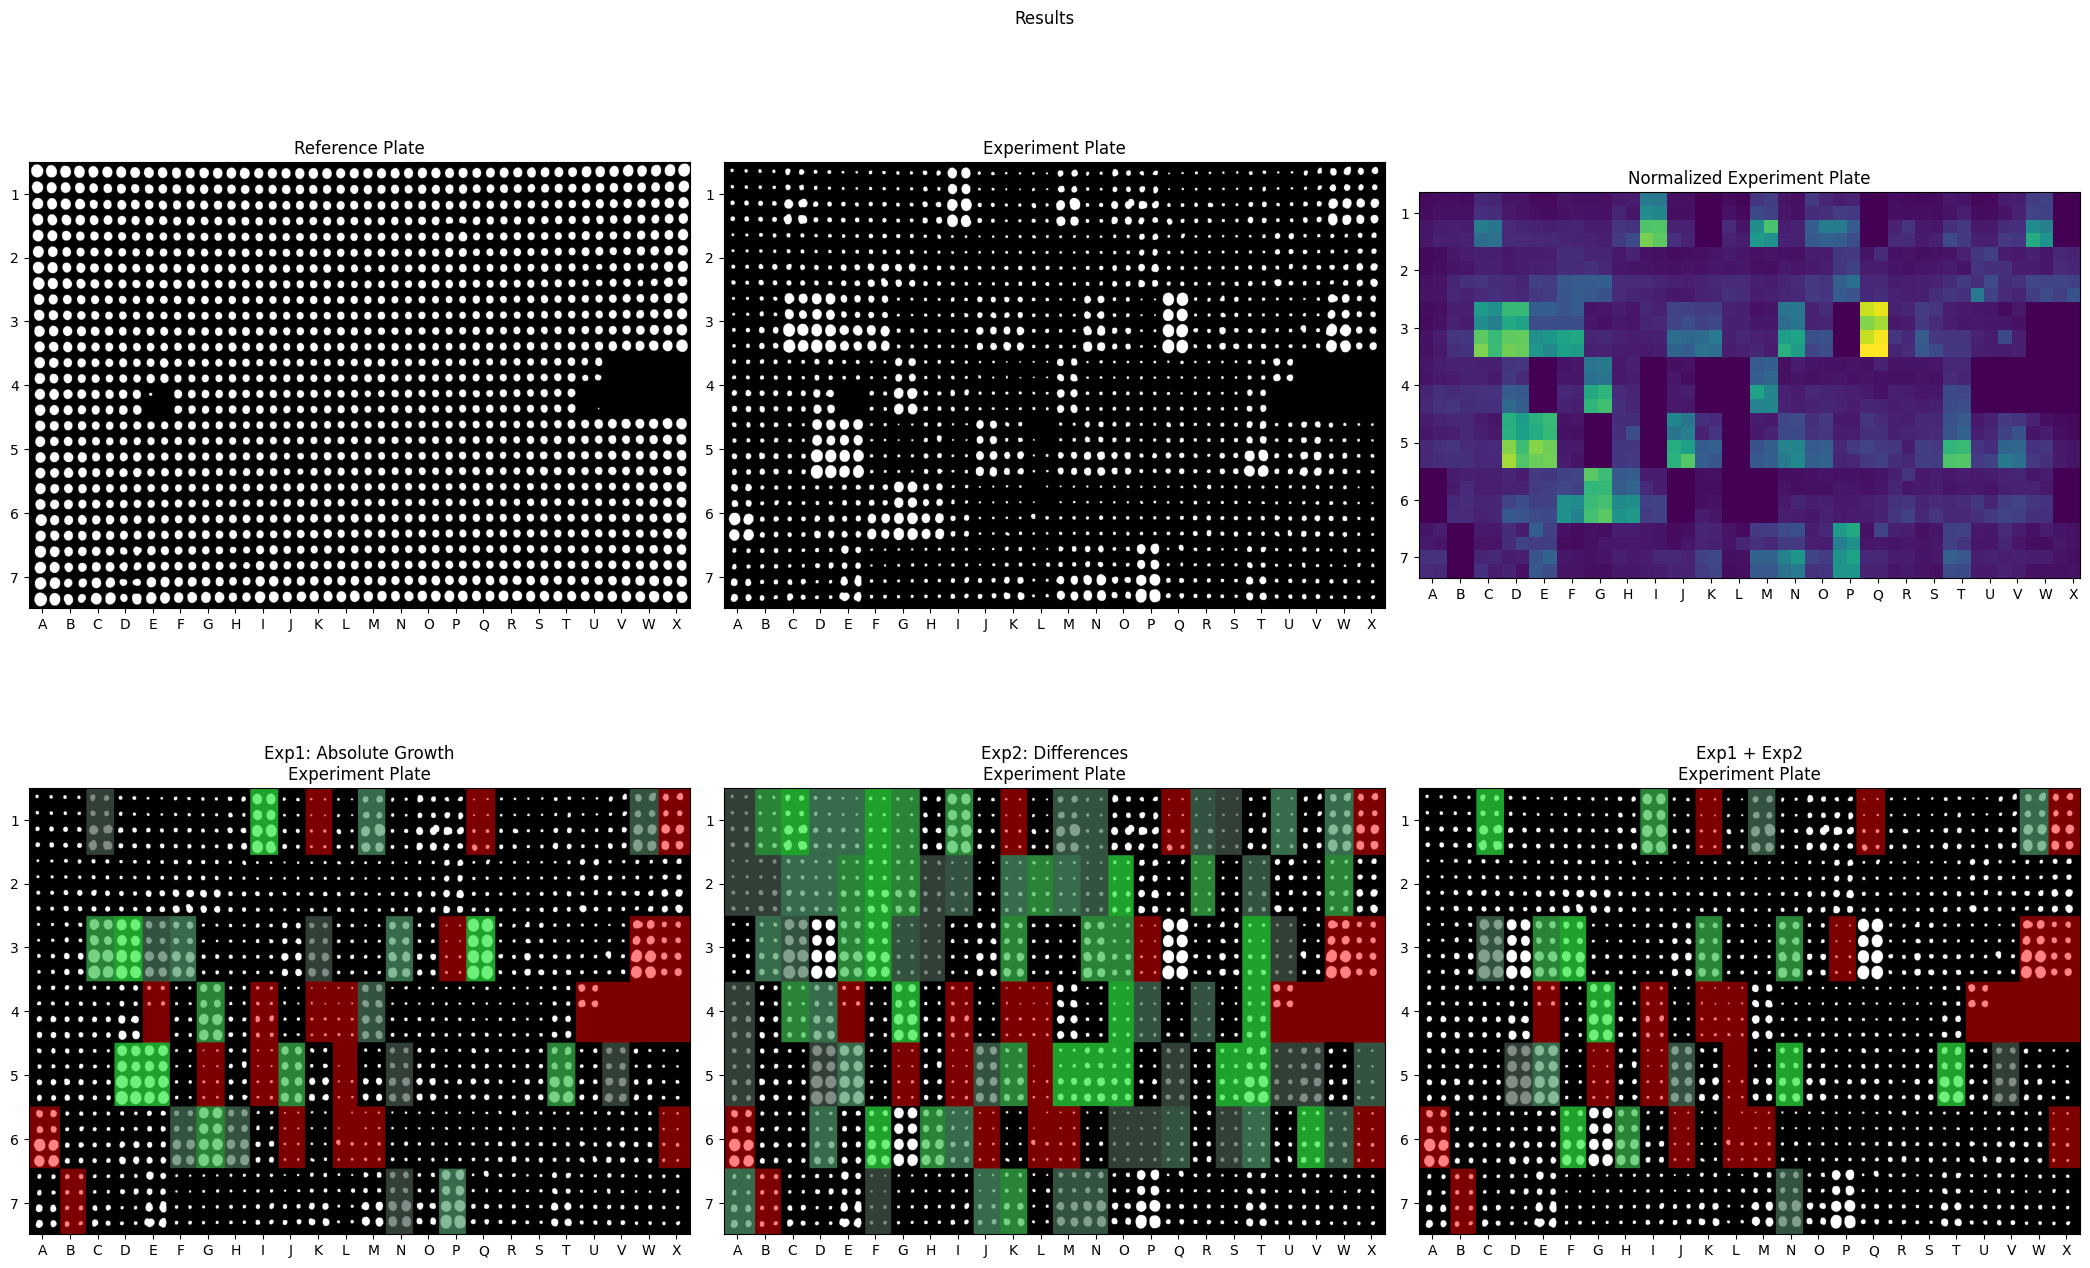

In [12]:
quadruples, minimum_size = evaluate(experiment_plate, 
                      reference_plate, 
                      sizes_experiment, 
                      sizes_reference, 
                      x_start, 
                      x_end, 
                      y_start, 
                      y_end, 
                      layout_names,
                      MIN_COLONY_SIZE, 
                      P_VALUE_NULLHYPOTHESIS, 
                      PERCENTILE, 
                      log_dir = save_results_folder+"Result_"+str(Path(path_to_experiment_plate).stem)+".pdf")

## 4. Save Data To Excel Sheet

In [14]:

data = {'Position': [quad.position[1]+" "+quad.position[0] for quad in quadruples], 
        'Name': [str(quad.name) for quad in quadruples], 
        'Exp1: Significant Size': ["yes" if (quad.absolute_size>minimum_size) else "no" for quad in quadruples],
        'Exp1: Absolut Size': [quad.absolute_size for quad in quadruples],
        'Exp1: Minimum Threshold': [minimum_size for quad in quadruples],

        'Exp2: Significant Difference': ["yes" if (quad.p_value<P_VALUE_NULLHYPOTHESIS) else "no" for quad in quadruples],
        'Exp2: P-Value': [quad.p_value for quad in quadruples], 
        'Exp2: Effect Size': [quad.effect_size for quad in quadruples], 
        'Exp2: Growth Factor': [quad.growthfactor for quad in quadruples],
        
        'Is Valid' : ["valid" if quad.is_valid else "invalid" for quad in quadruples], 
        'Reason': [quad.reason for quad in quadruples],

        'Bigger Row': [quad.bigger_row for quad in quadruples],

        'A1 Normalized': [str(quad.quadrupelA.sizes[0]) for quad in quadruples], 
        'A2 Normalized': [str(quad.quadrupelA.sizes[1]) for quad in quadruples], 
        'A3 Normalized': [str(quad.quadrupelA.sizes[2]) for quad in quadruples], 
        'A4 Normalized': [str(quad.quadrupelA.sizes[3]) for quad in quadruples], 
        'B1 Normalized': [str(quad.quadrupelB.sizes[0]) for quad in quadruples], 
        'B2 Normalized': [str(quad.quadrupelB.sizes[1]) for quad in quadruples], 
        'B3 Normalized': [str(quad.quadrupelB.sizes[2]) for quad in quadruples], 
        'B4 Normalized': [str(quad.quadrupelB.sizes[3]) for quad in quadruples],

        'A1 Raw Experiment': [str(quad.quadrupelA.sizes_exp[0]) for quad in quadruples], 
        'A2 Raw Experiment': [str(quad.quadrupelA.sizes_exp[1]) for quad in quadruples], 
        'A3 Raw Experiment': [str(quad.quadrupelA.sizes_exp[2]) for quad in quadruples], 
        'A4 Raw Experiment': [str(quad.quadrupelA.sizes_exp[3]) for quad in quadruples], 
        'B1 Raw Experiment': [str(quad.quadrupelB.sizes_exp[0]) for quad in quadruples], 
        'B2 Raw Experiment': [str(quad.quadrupelB.sizes_exp[1]) for quad in quadruples], 
        'B3 Raw Experiment': [str(quad.quadrupelB.sizes_exp[2]) for quad in quadruples], 
        'B4 Raw Experiment': [str(quad.quadrupelB.sizes_exp[3]) for quad in quadruples],

        'A1 Raw Reference': [str(quad.quadrupelA.sizes_ref[0]) for quad in quadruples], 
        'A2 Raw Reference': [str(quad.quadrupelA.sizes_ref[1]) for quad in quadruples], 
        'A3 Raw Reference': [str(quad.quadrupelA.sizes_ref[2]) for quad in quadruples], 
        'A4 Raw Reference': [str(quad.quadrupelA.sizes_ref[3]) for quad in quadruples], 
        'B1 Raw Reference': [str(quad.quadrupelB.sizes_ref[0]) for quad in quadruples], 
        'B2 Raw Reference': [str(quad.quadrupelB.sizes_ref[1]) for quad in quadruples], 
        'B3 Raw Reference': [str(quad.quadrupelB.sizes_ref[2]) for quad in quadruples], 
        'B4 Raw Reference': [str(quad.quadrupelB.sizes_ref[3]) for quad in quadruples],

        #'sort_by': [quad.effect_size if((quad.p_value<P_VALUE_NULLHYPOTHESIS) and (quad.absolute_size>minimum_size) and (quad.is_valid)) else -1 for quad in quadruples ]
} 

df = pd.DataFrame(data=data)  
# df = df.sort_values(by=['Is Valid'], ascending=False)
# n_valids = data['Is Valid'].count("valid")
# df[:n_valids] = df[:n_valids].sort_values(by=['Exp1: Significant Size'], ascending=False)
# n_significant_size = 0 
# for quad in quadruples: 
#     if(quad.is_valid and (quad.absolute_size>minimum_size)):
#         n_significant_size +=1
# df[:n_significant_size] = df[:n_significant_size].sort_values(['sort_by'], ascending=False)
# df = df.drop(columns = "sort_by")
df.to_excel(save_results_folder+"/Result_"+str(Path(path_to_experiment_plate).stem)+".xlsx")

print(f"INFO::Evaluation done. Results can be found here: {os.path.abspath(save_results_folder)}")

INFO::Evaluation done. Results can be found here: /media/hansel/SSD/Code/Hefekulturen/Results_May2024/Spa2


## Documentation of the Results Table

- **Position** marks the position of the quadruple A and B, so they can be found more easily on the generated PDF with experiment and reference plates. 
- **Name** is retrieved by the layout of the experiment which is defined by the plate name (differences between plates A,B,C)
- **Exp1: Significant Size** if 'yes', the result of Exp1, considering the abolute growth compared to other colonies is considered significant.
- **Exp1: Absolut Size** is the mean normalized size of all colonies in the quadruple which has grown bigger. 
- **Exp1: Minimum Threshold** is the threshold to define the absolute growth of quadruple A and B compared to others. The threshold is (usually) derived by a outlier detection, taking 1.5xIQR into account. Works with normalized sizes. IT compares the mean of the row which has been grown bigger (normalized).
- **Exp2: Significant Difference** if 'yes', the result of Exp1, considering the difference in growth between row A and B is considered significant.
- **Exp2: P-value** is the result of the statistical test to derive wheather quadruple A has been grown significantly different from row B. 
- **Exp2: Effect Size** defines the effect size of the statistical test (high effect size means more significant difference).
- **Exp2: Growth Factor** defines the factor x such that $mean(B_{norm}) \times x = mean(A_{norm})$, which means that $B$ has $x$ times the size of $A$. If $x$ is $< 1$, row A is bigger, if $x > 1$ B is bigger.
- **Is Valid** is marked as invalid, if it is likely that there is a measuring error
- **Reason** defines the reason if the quadriple was marked as invalid
- **Bigger Row** defines weather row A or B was growing bigger
- **A1 Normalized** defines the normalized size of the first colony in quadruple A
- **A2 Normalized** defines the normalized size of the second colony in quadruple A 
- **A3 Normalized** defines the normalized size of the third colony in quadruple A 
- **A4 Normalized** defines the normalized size of the fourth colony in quadruple A 
- **B1 Normalized** defines the normalized size of the first colony in quadruple B
- **B2 Normalized** defines the normalized size of the second colony in quadruple B 
- **B3 Normalized** defines the normalized size of the third colony in quadruple B
- **B4 Normalized** defines the normalized size of the fourth colony in quadruple B 

- **A1 Raw Experiment** defines the raw size of the first colony in quadruple A on the experiment plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **A2 Raw Experiment** defines the raw size of the second colony in quadruple A on the experiment plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **A3 Raw Experiment** defines the raw size of the third colony in quadruple A on the experiment plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **A4 Raw Experiment** defines the raw size of the fourth colony in quadruple A on the experiment plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **B1 Raw Experiment** defines the raw size of the first colony in quadruple B on the experiment plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **B2 Raw Experiment** defines the raw size of the second colony in quadruple B on the experiment plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **B3 Raw Experiment** defines the raw size of the third colony in quadruple B on the experiment plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **B4 Raw Experiment** defines the raw size of the fourth colony in quadruple B on the experiment plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.

- **A1 Raw Reference** defines the raw size of the first colony in quadruple A on the reference plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **A2 Raw Reference** defines the raw size of the second colony in quadruple A on the reference plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **A3 Raw Reference** defines the raw size of the third colony in quadruple A on the reference plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **A4 Raw Reference** defines the raw size of the fourth colony in quadruple A on the reference plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **B1 Raw Reference** defines the raw size of the first colony in quadruple B on the reference plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **B2 Raw Reference** defines the raw size of the second colony in quadruple B on the reference plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **B3 Raw Reference** defines the raw size of the third colony in quadruple B on the reference plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.
- **B4 Raw Reference** defines the raw size of the fourth colony in quadruple B on the reference plate. Will be -1, if smaller than `MIN_COLONY_SIZE`.


### Sorting
The results table is sorted in such way, that experiments that are significant in both Exp1 and Exp2 are at the very top. 
It follows experiments, that are significant in absolut growth (Exp1)
Finally, invalids are shown at the bottom.
